## **Wavelet**

The wavelet transform of a 1D signal results in a 2D scaleogram which contains a lot more information than just the time-series or just the Fourier Transform.

Such a scaleogram can not only be used to better understand the dynamical behavior of a system, but it can also be used to distinguish different types of signals produced by a system from each other.
If you record a signal while you are walking up the stairs or down the stairs, the scaleograms will look different. <span style="color:red">ECG measurements of people with a healthy heart will have different scaleograms than ECG measurements of people with arrhythmia</span>. Or measurements on a bearing, motor, rotor, ventilator, etc when it is faulty vs when it not faulty.

So by looking at the scaleograms we can distinguish a broken motor from a working one, a healthy person from a sick one, a person walking up the stairs from a person walking down the stairs, etc etc. But if you are as lazy as me, you probably don’t want to sift through thousands of scaleograms manually. One way to automate this process is to build a <span style="color:blue">Convolutional Neural Network </span> which can automatically detect the class each scaleogram belongs to and classify them accordingly.

In [59]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import matplotlib.dates as mdates

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from scipy import stats
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import HTML
keras.__version__

'2.3.1'

In [60]:
from helper_functions import create_train_test, split_sequences

In [61]:
import pywt
from scipy.fftpack import fft
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from scipy.signal import welch

In [62]:
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

#### Types of Wavelets for use

In [63]:
wavelet_families = pywt.families(short=False)
discrete_mother_wavelets = pywt.wavelist(kind='discrete')
continuous_mother_wavelets = pywt.wavelist(kind='continuous')
print("PyWavelets contains the following families: ")
print(wavelet_families)
print()
print("PyWavelets contains the following Continuous families: ")
print(continuous_mother_wavelets)
print()
print("PyWavelets contains the following Discrete families: ")
print(discrete_mother_wavelets)
print()

PyWavelets contains the following families: 
['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']

PyWavelets contains the following Continuous families: 
['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']

PyWavelets contains the following Discrete families: 
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7'

#### Creating segments

In [91]:
# Reload dataset
df = pd.read_csv('../../Features.csv', usecols=['Timestamp','Module','Type','Temp_Mod', 'VBus'], parse_dates=['Timestamp'])
#df.set_index('Timestamp', inplace=True, drop=True)

In [92]:
def create_segments_and_labels(df, time_steps, step, label_name, N_FEATURES):
    """
    This function receives a dataframe and returns the reshaped segments
    of the features as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
        step: overalpping
        label_name: name of column in the dataframe that contains the encoded labels
        N_Features: Number of features
    Returns:
        reshaped_segments
        labels:
    """

    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    #segments = []
    temp = []
    volt = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['Temp_Mod'].values[i: i + time_steps]
        ys = df['VBus'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        #segments.append([xs,ys])
        temp.append(xs)
        volt.append(ys)
        labels.append(label)
            
    # Current shape is (Samples, N Features, Time segments)
    # Bring the segments into a better shape (Samples, time_segments, N features)
    #reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    segments = np.zeros((np.shape(temp)[0], time_steps, N_FEATURES))
    for i in range(np.shape(temp)[0]):
        segments[i,:,0]=temp[i]
        segments[i,:,1]=volt[i]
    
    labels = np.asarray(labels)

    return segments, labels

In [93]:
LABEL = 'ModuleEncoded'
le = preprocessing.LabelEncoder()
df[LABEL] = le.fit_transform(df['Module'].values.ravel())
LABELS = df_train['Module'].unique()

In [94]:
split_date ='2019-05-01 00:00:05'
df_train = df.loc[df['Timestamp'] <= split_date]
df_test = df.loc[df['Timestamp'] >= split_date]

In [95]:
# The number of steps within one time segment
TIME_PERIODS = 256

# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 128
N_FEATURES = 2

In [96]:
x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS, STEP_DISTANCE, LABEL, N_FEATURES)
x_test, y_test = create_segments_and_labels(df_test, TIME_PERIODS, STEP_DISTANCE, LABEL, N_FEATURES)

In [103]:
input_width = x_train.shape[1]     # number of periods
num_channels = x_train.shape[2]    # number of sensors
num_classes = 15     # labels

n_samples = x_train.shape[0]
n_timesteps = x_train.shape[1]
n_features = 2
n_outputs = len(LABELS)
y_train_hot = to_categorical(y_train, num_classes)
y_test_hot = to_categorical(y_test, num_classes)

In [104]:
no_labels = len(np.unique(y_train[:]))

print('X train shape {}'.format(x_train.shape))
print('Labels format training set {}'.format(y_train_hot.shape))
print('X test shape {}'.format(x_test.shape))
print('Labels format testing set {}\n'.format(y_test_hot.shape))
print('n_samples {} (Samples from the original raw signal)\n'
      'n_timesteps {} (points)\n' 
      'n_features {} (measurements)\n'
      'n_outputs {} (number of classes)'.format(n_samples, TIME_PERIODS, n_features, n_outputs))
print("\nThe train dataset contains {} labels, with the following distribution:\n {}".
      format(np.shape(y_train)[0], Counter(y_train[:])))
print("\nThe test dataset contains {} labels, with the following distribution:\n {}".
      format(np.shape(y_test)[0], Counter(y_test[:])))

X train shape (42269, 256, 2)
Labels format training set (42269, 15)
X test shape (19033, 256, 2)
Labels format testing set (19033, 15)

n_samples 42269 (Samples from the original raw signal)
n_timesteps 256 (points)
n_features 2 (measurements)
n_outputs 15 (number of classes)

The train dataset contains 42269 labels, with the following distribution:
 Counter({2: 13032, 4: 3229, 7: 3204, 6: 3180, 0: 3156, 3: 2921, 5: 2157, 1: 2114, 9: 2048, 14: 1479, 8: 1476, 12: 1313, 13: 1189, 10: 1053, 11: 718})

The test dataset contains 19033 labels, with the following distribution:
 Counter({2: 6671, 4: 1677, 1: 1668, 3: 1661, 7: 1652, 12: 1071, 6: 834, 8: 799, 11: 626, 13: 602, 9: 513, 5: 375, 14: 364, 0: 284, 10: 236})


----------------------------------------------
The training set contains 108209 signals where each signal has 200 measurement samples and 2 components. The signals from the training set are loaded into a numpy ndarray of size (108209 , 200, 2).

Since the signal consists of nine components we have to apply the CWT for each signal.

### Plot the Scaleogram using the Continuous Wavelet Transform

```python
pywt.cwt(data, scales, wavelet) #One dimensional Continuous Wavelet Transform.

```

We must define a convenient mother wavelet and scale size for the continuous wavelet function pywt.cwt. I chose Morlet Mother Wavelet based on its most suitable shape. To select an appropriate range of scales, let’s consider the CWT coefficients of three different ranges 32, 64 and 128, represented as a scalogram

**In general, a smaller size of scales like 32 enables more focus of abrupt changes. As already mentioned, these suddenly changes are often the most important characteristics. Otherwise a wide range of scales like 128 provides more information about slowly changes, which can provide a better classification accuracy.**

It is manually feasible to differ between the different activities through the visualization of the CWT coefficients via a scalogram.

In [105]:
def split_indices_per_label(y):
    indicies_per_label = [[] for x in range(0,len(LABELS))]
    # loop over the six labels
    for i in range(len(LABELS)): 
        indicies_per_label[i] = np.where(y == i)[0]
    return indicies_per_label

def plot_cwt_coeffs_per_label(X, label_indicies, label_names, signal_index=0, sample_index=np.random.randint(1,100), 
                              scales=np.arange(1,65), wavelet='morl'):
    
    #dt = time[1]-time[0]
    fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(28,12))
    
    for ax, indices, name in zip(axs.flat, label_indicies, label_names):
        # apply  PyWavelets continuous wavelet transfromation function
        coeffs, freqs = pywt.cwt(X[indices[sample_index],:, signal_index], scales, wavelet)
        # create scalogram
        pcm=ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
        ax.set_title(name)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')   
    fig.colorbar(pcm, ax=axs[:,4])
    #plt.tight_layout()

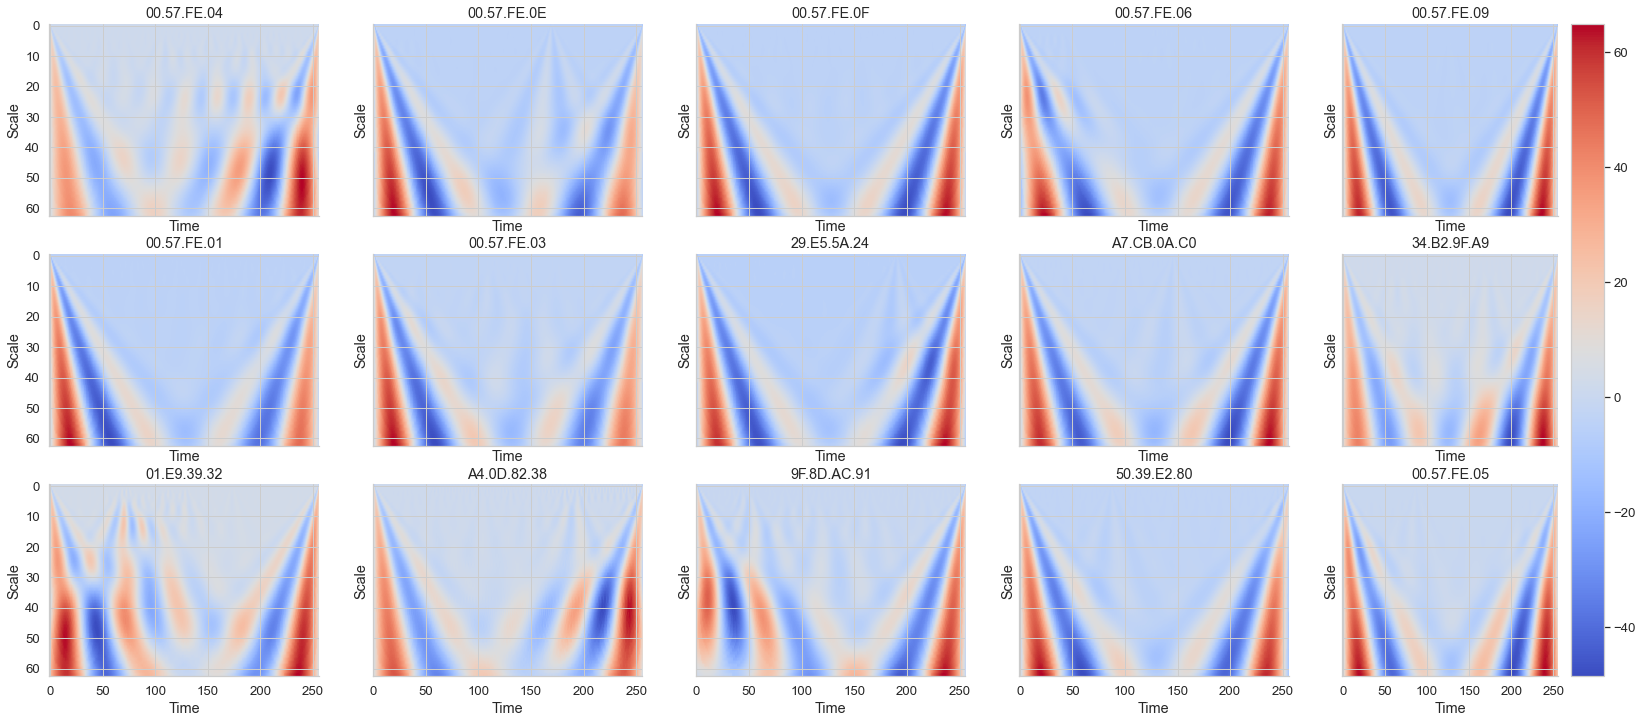

In [110]:
# list of list of sample indicies per activity
train_labels_indicies = split_indices_per_label(y_train)

#signal indicies: 0 = Temperature, 1 = Voltages
signal_index = 0    # signal index
sample_index = 100    # sample index of each label indicies list
scales = np.arange(1, 64) # range of scales
wavelet = 'morl'    # mother wavelet

plot_cwt_coeffs_per_label(x_train, train_labels_indicies, LABELS, signal_index, sample_index, scales, wavelet)

## **Prepare for Training with CWT**

Before we can start to feed a CNN, we must:
- transform the signals of the WSN dataset using the pywt.cwt function; and
- bring the resulting coefficients into a suitable format.

Using the Morlet Mother Wavelet and a scale size of 64 for the pywt.cwt function. Additionally, resize all coefficient matrices (64x200) to a square shape (64x64). This step is not absolutely necessary but saves many parameters and computation resources and at the same time we should not lose too many details of the images.

- Place the 2 scaleograms on top of each other and create one single image with 2 channels. Normally an image has either one channel  (grayscale image) or three channels (color image), but our CNN can just as easily handle images with 2 channels. The way the CNN works remains exactly the same, the only difference is that there will be 2 times more filters compared to an grayscale image and less than with a RGB image.

The CWT of a single signal-component (200 samples) results in an image of 200 by 200 pixels. So the scaleograms coming from the `n_signals` of the training dataset are stored in an numpy ndarray of size `(n_signals, n_samples, n_samples, n_features) = (108209, 200, 200, 2)`

In [235]:
from skimage.transform import resize

In [236]:
def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    
    n_samples = X.shape[0] 
    n_features = X.shape[2] 
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_features), dtype = 'float32')
    
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print('Sample number {}'.format(sample))
        for feature in range(n_features):
            serie = X[sample, :, feature]
            # continuous wavelet transform 
            coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
            X_cwt[sample,:,:,feature] = rescale_coeffs
    return X_cwt

In [237]:
# amount of pixels in X and Y 
rescale_size = 64
# determine the max scale size, this is for adjust the images
# (to n_scales X n_pixels)
n_scales = 64

In [238]:
X_train_cwt = create_cwt_images(x_train, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")

Sample number 0
Sample number 1000
Sample number 2000
Sample number 3000
Sample number 4000
Sample number 5000
Sample number 6000
Sample number 7000
Sample number 8000
Sample number 9000
Sample number 10000
Sample number 11000
Sample number 12000
Sample number 13000
Sample number 14000
Sample number 15000
Sample number 16000
Sample number 17000
Sample number 18000
Sample number 19000
Sample number 20000
Sample number 21000
Sample number 22000
Sample number 23000
Sample number 24000
Sample number 25000
Sample number 26000
Sample number 27000
Sample number 28000
Sample number 29000
Sample number 30000
Sample number 31000
Sample number 32000
Sample number 33000
Sample number 34000
Sample number 35000
Sample number 36000
Sample number 37000
Sample number 38000
Sample number 39000
Sample number 40000
Sample number 41000
Sample number 42000
shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: (42269, 64, 64, 2)


In [239]:
X_test_cwt = create_cwt_images(x_test, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test_cwt.shape}")

Sample number 0
Sample number 1000
Sample number 2000
Sample number 3000
Sample number 4000
Sample number 5000
Sample number 6000
Sample number 7000
Sample number 8000
Sample number 9000
Sample number 10000
Sample number 11000
Sample number 12000
Sample number 13000
Sample number 14000
Sample number 15000
Sample number 16000
Sample number 17000
Sample number 18000
Sample number 19000
shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: (19033, 64, 64, 2)


In [183]:
# Save a multidimensional array
scipy.io.savemat('X_train_cwt.mat', mdict={'out': X_train_cwt}, oned_as='row')
scipy.io.savemat('X_test_cwt.mat', mdict={'out': X_test_cwt}, oned_as='row')

In [35]:
# Now load in the data from the .mat that was just saved
X_train_cwt = scipy.io.loadmat('X_train_cwt.mat')['out']
X_test_cwt = scipy.io.loadmat('X_test_cwt.mat')['out']
#matdata = scipy.io.loadmat('X_train_cwt.mat')['out']
# And just to check if the data is the same:
# assert np.all(X_train_cwt == matdata['out'])
# print matdata.keys()

In [240]:
print(X_train_cwt.shape)
print(X_test_cwt.shape)

(42269, 64, 64, 2)
(19033, 64, 64, 2)


## Training the Convolutional Neural Network with the CWT

When using the `sparse_categorical_crossentropy` loss, your targets should be integer targets. If you have categorical targets, you should use categorical_crossentropy.

In [241]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
#import keras (high level API) wiht tensorflow as backend
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics

TensorFlow version: 2.0.0


In [242]:
# shape of the input images
input_shape = (X_train_cwt.shape[1], X_train_cwt.shape[2], X_train_cwt.shape[3])
print(input_shape)

(64, 64, 2)


In [243]:
def build_cnn_model(input_shape, activation='relu', kernel_size=(4,4), n_filters=32, n_filters_fcl=128, padding='same'):
    # Basic LeNet5 architecture
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(filters=n_filters, kernel_size=kernel_size, 
                     activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters= n_filters*2, kernel_size=kernel_size, 
                     activation = activation, padding = 'same', 
                     kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())
    
    model.add(Dropout(0.5))
    model.add(Conv2D(filters= n_filters*2, kernel_size=kernel_size, 
                     activation = activation, padding = 'same', 
                     kernel_initializer = "he_normal"))
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    
    # 3 Full connected layer
    model.add(Dense(n_filters_fcl, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dropout(0.5))
    model.add(Dense(n_filters_fcl/2, activation = activation, kernel_initializer = "he_normal"))
    #model.add(Dropout(0.5))
    model.add(Dense(n_outputs, activation = 'softmax')) # 15 classes
    
    # summarize the model
    print(model.summary())
    return model

In [244]:
def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs=10):

    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='sparse_categorical_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    return model, history

In [164]:
# create cnn model
cnn_model = build_cnn_model(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [98]:
# train cnn model
batch_size = 64
n_epochs = 20
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train_cwt, y_train, X_test, y_test, batch_size, n_epochs)

Train on 75746 samples, validate on 32463 samples
Epoch 1/20
75746/75746 [==============================] - 487s 6ms/sample - loss: 1.3539 - sparse_categorical_accuracy: 0.5166 - val_loss: 0.8918 - val_sparse_categorical_accuracy: 0.6505
Epoch 2/20
75746/75746 [==============================] - 491s 6ms/sample - loss: 0.9024 - sparse_categorical_accuracy: 0.6411 - val_loss: 0.7373 - val_sparse_categorical_accuracy: 0.7017
Epoch 3/20
75746/75746 [==============================] - 500s 7ms/sample - loss: 0.7895 - sparse_categorical_accuracy: 0.6849 - val_loss: 0.7418 - val_sparse_categorical_accuracy: 0.7328
Epoch 4/20
75746/75746 [==============================] - 492s 6ms/sample - loss: 0.7108 - sparse_categorical_accuracy: 0.7144 - val_loss: 0.6211 - val_sparse_categorical_accuracy: 0.7734
Epoch 5/20
75746/75746 [==============================] - 485s 6ms/sample - loss: 0.6645 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.6013 - val_sparse_categorical_accuracy: 0.7763
Epoch 6/20

In [101]:
history_df = pd.DataFrame(cnn_history.history) 

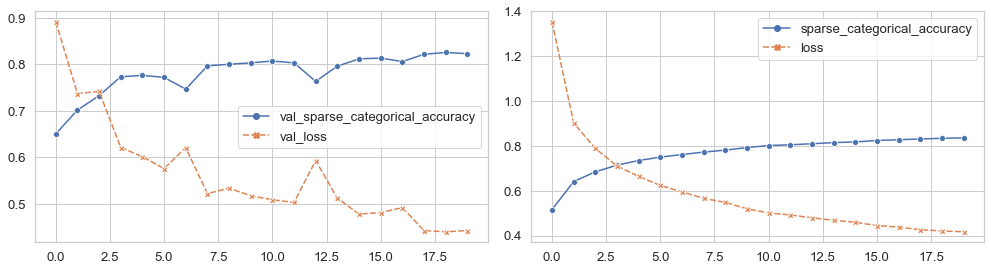

In [107]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize = (14,4))
sns.lineplot(data=history_df[['val_sparse_categorical_accuracy','val_loss']], ax=axarr[0], markers=True)
sns.lineplot(data=history_df[['sparse_categorical_accuracy','loss']], ax=axarr[1], markers=True)
plt.tight_layout()

Maybe increasing the number of epochs and adding some droput. This was using 20 epochs and 2 Droput layers. So now let's increase the epochs, and move the Dropout layer before the output layer. Also now i'm validation with the real data and not a split of 30% and using 16 filters in the first layer, also lower to 16 the fully connected layer. Results:....Not good enough, still looks overfitted.


Another alternative is to change the size of the segments and try to get more changes in the Spectogram.

In [245]:
cnn_model_2 = build_cnn_model(input_shape, n_filters=32)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 64, 64, 32)        1056      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 64)        32832     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 64)        65600     
_________________________________________________________________
dropout_37 (Dropout)         (None, 16, 16, 64)      

In [ ]:
# train cnn model
batch_size = 128
n_epochs = 50
trained_cnn_model_2, cnn_history_2 = compile_and_fit_model(cnn_model, X_train_cwt, y_train, X_test_cwt, y_test, batch_size, n_epochs)

In [215]:
history_df_2 = pd.DataFrame(cnn_history_2.history) 

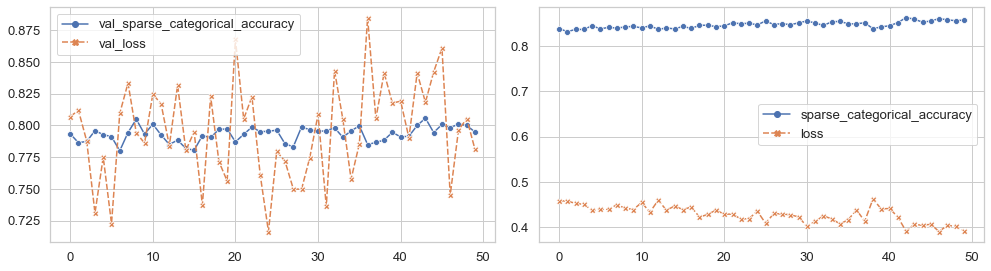

In [216]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize = (14,4))
sns.lineplot(data=history_df_2[['val_sparse_categorical_accuracy','val_loss']], ax=axarr[0], markers=True)
sns.lineplot(data=history_df_2[['sparse_categorical_accuracy','loss']], ax=axarr[1], markers=True)
plt.tight_layout()

In [217]:
# make predictions for test data
y_pred = trained_cnn_model.predict_classes(X_test_cwt)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.47%


In [218]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.99      0.60        79
           1       0.94      0.50      0.65       425
           2       0.96      0.93      0.95      1702
           3       0.91      0.91      0.91       436
           4       0.78      0.87      0.83       420
           5       1.00      0.02      0.04        94
           6       0.67      0.82      0.73       214
           7       0.89      0.83      0.86       435
           8       0.84      0.78      0.81       205
           9       0.26      0.75      0.39       133
          10       0.46      0.78      0.58        50
          11       0.96      0.71      0.82       156
          12       0.75      0.31      0.44       274
          13       0.86      0.94      0.90       161
          14       0.27      0.55      0.37        88

    accuracy                           0.79      4872
   macro avg       0.73      0.71      0.66      4872
weighted avg       0.85   

In [220]:
def create_confusion_matrix(y_pred, y_test):    
    #calculate the confusion matrix
    confmat = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig, ax = plt.subplots(figsize=(16,10))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=0.5)

    n_labels = len(LABELS)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABELS)
    ax.set_yticklabels(LABELS)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
    
    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

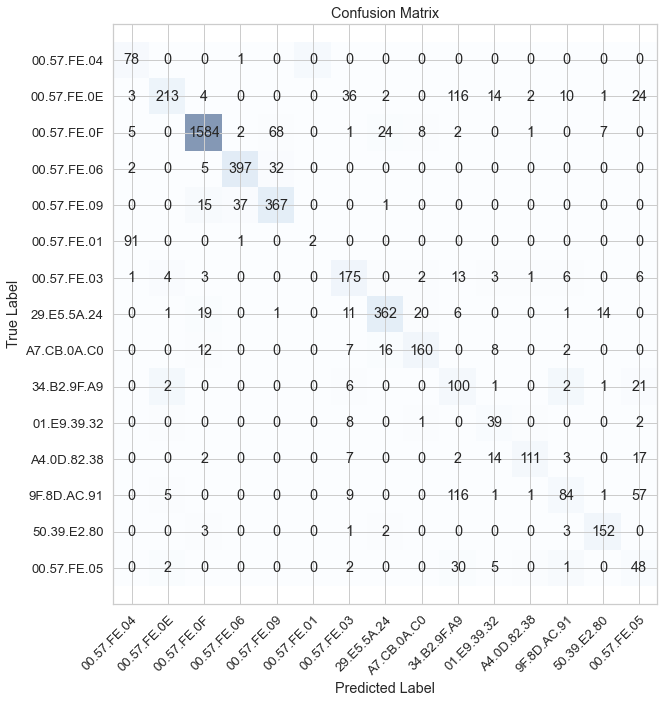

In [221]:
create_confusion_matrix(y_test, y_pred)